In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

In [2]:
from astral.sun import sun # https://astral.readthedocs.io/en/latest/
from astral import LocationInfo
stgallen_city = LocationInfo('St. Gallen', 'Switzerland', 'Europe/Zurich', 47.424492554512014, 9.376722938498643)

In [3]:
solar = pd.read_csv('../../data/strom-stg-bismaerz25.csv', sep=';', encoding='utf-8', low_memory=False, parse_dates=['DateTime (Local Time)'])

# Missing

In [4]:
solar['datetime'] = solar["DateTime (Local Time)"].apply(lambda x: dt.datetime(x.year,x.month,x.day,x.hour,x.minute))

In [5]:
solarsubset = solar[(solar["Name"] == "Werkhof St.Galler Stadtwerke") & (solar["Name des Smart-Me Zählers"] == "PV Steinachstrasse 49")].copy()

In [6]:
solarsubset.describe()

,Additional Energy Import,Active Energy Import Total,Additional Energy Export,Active Energy Export Total,Leistung in kWp,Anzahl Module,Wechselrichterleistung in kVA,Fläche in m2,datetime
count,77049.000000,77049.000000,7.704900e+04,7.704900e+04,7.704900e+04,77049.0,77049.0,77049.0,77049
mean,0.641872,12314.551853,1.910477e+03,5.199934e+07,2.178000e+01,198.0,20.0,178.0,2024-02-06 08:01:40.130046976
min,0.000000,11928.606000,0.000000e+00,3.235235e+07,2.178000e+01,198.0,20.0,178.0,2023-01-01 00:00:00
25%,0.000000,12092.211000,0.000000e+00,4.350226e+07,2.178000e+01,198.0,20.0,178.0,2023-07-20 16:30:00
50%,0.000000,12278.319000,0.000000e+00,5.112640e+07,2.178000e+01,198.0,20.0,178.0,2024-02-06 07:45:00
75%,0.000000,12566.423000,5.100260e+02,6.331640e+07,2.178000e+01,198.0,20.0,178.0,2024-08-24 23:45:00
max,12474.352000,12719.668000,3.910873e+07,6.943864e+07,2.178000e+01,198.0,20.0,178.0,2025-03-13 14:49:00
std,87.679768,244.370452,2.119053e+05,1.145631e+07,3.552737e-15,0.0,0.0,0.0,NaN


In [7]:
solarsubset.sort_values("datetime", inplace=True)
solarsubset.reset_index(inplace=True)

In [8]:
idx = pd.date_range(solarsubset["datetime"].min(), solarsubset["datetime"].max(), freq='15min')
missing = idx[~idx.isin(solarsubset["datetime"])]
toomuch = solarsubset["datetime"][~solarsubset["datetime"].isin(idx)]
print(f"Missing: {len(missing)} \n{missing}")
print(f"Too much: {len(toomuch)} \n{toomuch}")

Missing: 9 
DatetimeIndex(['2023-03-26 02:00:00', '2023-03-26 02:15:00',
               '2023-03-26 02:30:00', '2023-03-26 02:45:00',
               '2024-02-22 08:00:00', '2024-03-31 02:00:00',
               '2024-03-31 02:15:00', '2024-03-31 02:30:00',
               '2024-03-31 02:45:00'],
              dtype='datetime64[ns]', freq=None)
Too much: 6 
35036   2023-12-31 23:58:00
40061   2024-02-22 07:51:00
54909   2024-07-26 00:57:00
55482   2024-07-31 23:58:00
70171   2024-12-31 23:59:00
77048   2025-03-13 14:49:00
Name: datetime, dtype: datetime64[ns]


In [9]:
len(idx), len(solarsubset["datetime"]), len(missing), len(toomuch)

(77052, 77049, 9, 6)

In [10]:
# 9 "wrong"

# Wrong Readings

In [11]:
solarsubset["Additional Energy Export"].sort_values(ascending=True).head(10)

38524    0.0
32457    0.0
32458    0.0
32459    0.0
32460    0.0
32461    0.0
32462    0.0
32463    0.0
32464    0.0
32456    0.0
Name: Additional Energy Export, dtype: float64

In [12]:
solarsubset["Additional Energy Export"].sort_values(ascending=False).head(10)

70172    3.910873e+07
55483    3.382808e+07
35037    2.548245e+07
0        1.169483e+07
43918    4.229391e+03
12916    4.085751e+03
52466    4.062569e+03
49010    4.047510e+03
10995    4.012038e+03
9936     4.007349e+03
Name: Additional Energy Export, dtype: float64

#### Values cannot be this high since the solar panel is rated much lower.

#### If the panel had produced said values over the course of 15 minutes, it would have to be rated much higher:

In [13]:
alleged_max_kWh = solarsubset["Additional Energy Export"].max() /1000
print(f"Alleged rating: {alleged_max_kWh / (1/4) /1000:.2f} MW")

Alleged rating: 156.43 MW


#### This would be more than 9x of what the [most powerful (commercially deployed) wind turbine](https://en.wikipedia.org/wiki/List_of_most_powerful_wind_turbines) currently produces.

In [14]:
solarsubset["Leistung in kWp"].max()

21.78

In [15]:
theomax_15min_Wh = solarsubset["Leistung in kWp"].max() * (1/4) * 1000
theomax_15min_Wh

5445.0

We divide the max power by 4 to get the max power over 15 minutes, and then multiply by 1000 to get Wh.

In [16]:
solarsubset[solarsubset["Additional Energy Export"] > theomax_15min_Wh]

,index,DateTime (Local Time),smart-me ID,Name,Name des Smart-Me Zählers,Additional Energy Import,Active Energy Import Total,Additional Energy Export,Active Energy Export Total,Unit,Link,Modultyp,Leistung in kWp,Anzahl Module,Leistung / Modul in Wp,Wechselrichterleistung in kVA,Fläche in m2,Geo Shape,Geo Point,datetime
0,413388,2023-01-01 00:00:00+01:00,115a4cd6-c5b2-d6a6-14dc-b03078644337,Werkhof St.Galler Stadtwerke,PV Steinachstrasse 49,11765.766,11928.606,1.169483e+07,3.235235e+07,Wh,https://sgsw.solarlog-web.ch/40472.html,Siemens SM110,21.78,198,110,20.0,178,"{""coordinates"": [[[9.384719638540817, 47.43109...","47.4312365481, 9.38471976238",2023-01-01
35037,872546,2024-01-01 00:00:00+01:00,115a4cd6-c5b2-d6a6-14dc-b03078644337,Werkhof St.Galler Stadtwerke,PV Steinachstrasse 49,12076.213,12252.067,2.548245e+07,5.055871e+07,Wh,https://sgsw.solarlog-web.ch/40472.html,Siemens SM110,21.78,198,110,20.0,178,"{""coordinates"": [[[9.384719638540817, 47.43109...","47.4312365481, 9.38471976238",2024-01-01
55483,339444,2024-08-01 00:00:00+02:00,115a4cd6-c5b2-d6a6-14dc-b03078644337,Werkhof St.Galler Stadtwerke,PV Steinachstrasse 49,12348.196,12532.135,3.382808e+07,6.140194e+07,Wh,https://sgsw.solarlog-web.ch/40472.html,Siemens SM110,21.78,198,110,20.0,178,"{""coordinates"": [[[9.384719638540817, 47.43109...","47.4312365481, 9.38471976238",2024-08-01
70172,796728,2025-01-01 00:00:00+01:00,115a4cd6-c5b2-d6a6-14dc-b03078644337,Werkhof St.Galler Stadtwerke,PV Steinachstrasse 49,12474.352,12662.326,3.910873e+07,6.743340e+07,Wh,https://sgsw.solarlog-web.ch/40472.html,Siemens SM110,21.78,198,110,20.0,178,"{""coordinates"": [[[9.384719638540817, 47.43109...","47.4312365481, 9.38471976238",2025-01-01


In [17]:
len(solarsubset[solarsubset["Additional Energy Export"] > theomax_15min_Wh])
# 4 wrong entries

4

In [18]:
# filter out data above theoretical maximum
solarsubset = solarsubset[solarsubset["Additional Energy Export"] <= theomax_15min_Wh]

# Production at Sunrise and Sunset

- Dawn = Morgengrauen
- Sunrise = Sonnenaufgang
- Sunset = Sonnenuntergang
- Dusk = Abenddämmerung

In [19]:
custom_lambda = lambda date: sun(stgallen_city.observer, date, tzinfo=stgallen_city.timezone)

for i in ["dawn", "sunrise", "sunset", "dusk"]:
    solarsubset[i] = solarsubset["datetime"].apply(lambda x: custom_lambda(x)[i])
    solarsubset[i] = pd.to_datetime(solarsubset[i])  # Ensure datetime64[ns]
solarsubset.head(3)

,index,DateTime (Local Time),smart-me ID,Name,Name des Smart-Me Zählers,Additional Energy Import,Active Energy Import Total,Additional Energy Export,Active Energy Export Total,Unit,...,Leistung / Modul in Wp,Wechselrichterleistung in kVA,Fläche in m2,Geo Shape,Geo Point,datetime,dawn,sunrise,sunset,dusk
1,413393,2023-01-01 00:15:00+01:00,115a4cd6-c5b2-d6a6-14dc-b03078644337,Werkhof St.Galler Stadtwerke,PV Steinachstrasse 49,0.0,11928.606,0.0,3.235235e+07,Wh,...,110,20.0,178,"{""coordinates"": [[[9.384719638540817, 47.43109...","47.4312365481, 9.38471976238",2023-01-01 00:15:00,2023-01-01 07:33:59.145297+01:00,2023-01-01 08:10:19.323545+01:00,2023-01-01 16:41:41.996604+01:00,2023-01-01 17:18:02.373245+01:00
2,15591,2023-01-01 00:30:00+01:00,115a4cd6-c5b2-d6a6-14dc-b03078644337,Werkhof St.Galler Stadtwerke,PV Steinachstrasse 49,0.0,11928.606,0.0,3.235235e+07,Wh,...,110,20.0,178,"{""coordinates"": [[[9.384719638540817, 47.43109...","47.4312365481, 9.38471976238",2023-01-01 00:30:00,2023-01-01 07:33:59.145297+01:00,2023-01-01 08:10:19.323545+01:00,2023-01-01 16:41:41.996604+01:00,2023-01-01 17:18:02.373245+01:00
3,173585,2023-01-01 00:45:00+01:00,115a4cd6-c5b2-d6a6-14dc-b03078644337,Werkhof St.Galler Stadtwerke,PV Steinachstrasse 49,0.0,11928.606,0.0,3.235235e+07,Wh,...,110,20.0,178,"{""coordinates"": [[[9.384719638540817, 47.43109...","47.4312365481, 9.38471976238",2023-01-01 00:45:00,2023-01-01 07:33:59.145297+01:00,2023-01-01 08:10:19.323545+01:00,2023-01-01 16:41:41.996604+01:00,2023-01-01 17:18:02.373245+01:00


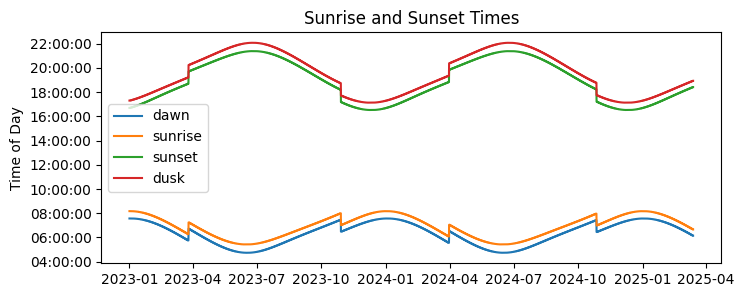

In [20]:
fig, ax = plt.subplots(figsize=(8, 3))

for col in ["dawn", "sunrise", "sunset", "dusk"]:
    times_in_seconds = (
        solarsubset[col].dt.hour * 3600 +
        solarsubset[col].dt.minute * 60 +
        solarsubset[col].dt.second
    )
    ax.plot(solarsubset["datetime"], times_in_seconds, label=col)

# Set y-axis ticks to hourly steps (every 3600 seconds)
ax.yaxis.set_major_locator(ticker.MultipleLocator(7200))

# Format y-axis ticks as HH:MM:SS
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: time.strftime('%H:%M:%S', time.gmtime(x))))

ax.set_title("Sunrise and Sunset Times")
ax.set_ylabel("Time of Day")
ax.legend()
plt.show()



In [21]:
solarsubset[(solarsubset["Additional Energy Export"] > 0) &                 # If Solar Panel is producing energy
            (solarsubset["DateTime (Local Time)"] <= solarsubset["dawn"])]  # and earlier than dawn
# should return empty DataFrame as solar panels should not produce energy at night

,index,DateTime (Local Time),smart-me ID,Name,Name des Smart-Me Zählers,Additional Energy Import,Active Energy Import Total,Additional Energy Export,Active Energy Export Total,Unit,...,Leistung / Modul in Wp,Wechselrichterleistung in kVA,Fläche in m2,Geo Shape,Geo Point,datetime,dawn,sunrise,sunset,dusk


In [22]:
solarsubset[(solarsubset["Additional Energy Export"] > 0) &                 # If Solar Panel is producing energy
            (solarsubset["DateTime (Local Time)"] >= solarsubset["dusk"])]  # and it is later than dusk
# should return empty DataFrame as solar panels should not produce energy at night

,index,DateTime (Local Time),smart-me ID,Name,Name des Smart-Me Zählers,Additional Energy Import,Active Energy Import Total,Additional Energy Export,Active Energy Export Total,Unit,...,Leistung / Modul in Wp,Wechselrichterleistung in kVA,Fläche in m2,Geo Shape,Geo Point,datetime,dawn,sunrise,sunset,dusk
